# Classification Tree
Implementation (numba-optimized for some parts) of Ordinary Binary Classification Trees (OBCTs)

In [1]:
%%html
<style>.container {width: 98%}</style>

In [2]:
from __future__ import annotations
import json
import re
import pprint

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

import numba

In [8]:
class Node(dict):
    """
    Representation of tree node kept as simple as possible using a dictionary
    """
    
    
    def __init__(self, y_ind=None, sample_weights=None, depth=None):
        self["y_ind"] = y_ind
        self["sample_weights"] = sample_weights
        self["depth"] = depth
        
        self["is_leaf"] = False
        self["feature_i"] = None
        self["split_value"] = None
        self["label"] = None

        self["yes"] = None
        self["no"] = None

    def __repr__(self):
        if self["is_leaf"]:
            return str({k: v for k, v in zip(self.keys(), self.values()) if k in ["label"]})
        else:
            return str({
                "expr": f"feature_{self['feature_i']} <= {self['split_value']}",
                "yes": self["yes"],
                "no": self["no"]
            })


class ClassificationTree(BaseEstimator, ClassifierMixin):
    """
    Fit an Ordinary Binary Classification tree (OBCT) using node impurity (class entropy) criterion for splitting

    Attributes
    ----------
    max_depth : int
        Maximum depth the tree can grow
    
    min_leaf_samples : int
        Minimum number of samples per leaf

    min_delta_impurity: float
        Minimum impurity decrease. If impurity decrease is not above this value, tree growing stops

    Methods
    -------
    create_node(node)
        For a given node, selects in a greedy way the feature and the corresponding split value 
        that maximally decreases impurity. Then decides if the node is a leaf node, otherwise
        assignes its childre ("yes" and "no")
    
    fit(X, y)
        Iteratively grows the decision tree by calling the ``create_node`` method starting from
        the root tree node
        
    __predict_once(x)
        Traverses the fitted tree by applying the conditions on the given sample and returns the leaf label
        
    predict(X)
        Calls ``__predict_once`` iteratively for all given samples in X
        
    get_depth()
        Returns the height (max depth) of the fitted tree
    """
    
    
    def __init__(self, max_depth: int = 10, min_leaf_samples: int = 1, min_delta_impurity: float = 0.0):
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.min_delta_impurity = min_delta_impurity
        
        self.root_node = None
        self.verbose_fit = False
    
    
    def fit(self, X: np.ndarray, y: np.ndarray, sample_weights: np.ndarray = None, verbose_fit: bool = False) -> ClassificationTree:
        """
        Iteratively traverses (inorder) and grows the decision tree by calling the ``create_node`` 
        method starting from the root tree node
        
        Parameters
        ----------
        X : numpy.ndarray
            Array of training samples with shape (n_samples, n_features)
        
        y : numpy.ndarray
            Array of training targets with shape (n_samples,)
            
        sample_weights : numpy.ndarray
            Array of weights (normalized) for each sample. If None, equal weighting is assumed
            
        verbose_fit : bool
            If True, the tree is pretty printed at the end of the training
        """
        
        
        if sample_weights is None:
            sample_weights = np.ones(X.shape[0]) / X.shape[0]
        
        
        root_node = Node(y_ind=np.arange(X.shape[0]), sample_weights=sample_weights, depth=1)

        # Iterative in-order traversal and growing of the tree
        current = root_node
        stack = []
        while True:
            self.create_node(current, X, y)
            if current is not None:
                stack.append(current)
                current = current["yes"]
            elif len(stack) > 0:
                current = stack.pop()
                current = current["no"]
            else:
                break
                
        self.root_node = root_node
        self.verbose_fit = verbose_fit
        
        return self
    
    
    def create_node(self, node: Node, X: np.ndarray, y: np.ndarray):
        """
        For a given node, selects in a greedy way the feature and the corresponding split value 
        that maximally decreases impurity. Then decides if the node is a leaf node, otherwise
        assignes its children ("yes" and "no")

        Parameters
        ----------
        node : Node
            A given tree node
        node
        """


        if not node:
            return

        # Subsets of initial samples X and y corresponding to current node
        y_t_ind = node["y_ind"]
        
        X_t = X[y_t_ind, :]
        y_t = y[y_t_ind]
        sample_weights_t = node["sample_weights"]

        n_samples, n_features = X_t.shape

        # Apply max depth and min leaf samples critiria
        if node["depth"] >= self.max_depth or n_samples * sample_weights_t.sum() <= self.min_leaf_samples:
            classes_t = np.unique(y_t)
            node["is_leaf"] = True
            node["label"] = classes_t[np.argmax([proba(c, y_t, sample_weights_t) for c in classes_t])]
            return

        I_t = impurity(y_t, sample_weights_t)
        N_t = n_samples
        delta_imp_t = np.zeros(n_features)
        thresholds_t = np.zeros(n_features)

        # Double loop: outer for best feature search and inner for best split value search
        for fi, f in enumerate(range(n_features)):
            X_f = (X_t[:, f])
            unique_vals = np.sort(np.unique(X_f))
            if unique_vals.shape[0] <= 1:
                continue

            thresholds_f = (unique_vals[0:-1] + unique_vals[1:]) / 2

            delta_imp_f = np.empty(thresholds_f.shape[0])  # impurities for current feature
            delta_imp_f = iterate_thresholds(thresholds_f, X_f, y_t, I_t, sample_weights_t, delta_imp_f)
            delta_imp_max_i = np.argmax(delta_imp_f)

            thresholds_t[fi] = thresholds_f[delta_imp_max_i]
            delta_imp_t[fi] = delta_imp_f[delta_imp_max_i]

        f_best_t = np.argmax(delta_imp_t)
        a_best_t = thresholds_t[np.argmax(delta_imp_t)]

        # Apply min impurity decrease critirion
        if np.max(delta_imp_t) < self.min_delta_impurity:
            classes_t = np.unique(y_t)
            node["is_leaf"] = True
            node["label"] = classes_t[np.argmax([proba(c, y_t, sample_weights_t) for c in classes_t])]
            return

        cond = (X_t[:, f_best_t] <= a_best_t)
        if (X_t[cond, :].shape[0] == n_samples) or (X_t[~cond, :].shape[0] == n_samples):
            classes_t = np.unique(y_t)
            node["is_leaf"] = True
            node["label"] = classes_t[np.argmax([proba(c, y_t, sample_weights_t) for c in classes_t])]
            return

        node["expression"] = f"feature_{f_best_t} <= {a_best_t}"
        node["feature_i"] = f_best_t
        node["split_value"] = a_best_t

        # Assign children nodes since the current node is not a leaf node
        node["yes"] = Node(y_ind=y_t_ind[cond], sample_weights=sample_weights_t[cond], depth=node["depth"] + 1)
        node["no"] = Node(y_ind=y_t_ind[~cond], sample_weights=sample_weights_t[~cond], depth=node["depth"] + 1)
    
    
    def __predict_once(self, x):
        """
        Traverses the fitted tree by applying the conditions on the given sample and returns 
        the leaf label
        
        Parameters
        ----------
        
        x : numpy.ndarray
            Array of size (n_features,) (1D)
        """
        
        
        node = self.root_node
        while True:
            if node["is_leaf"]:
                return node["label"]
            feature_i = node["feature_i"]
            split_value = node["split_value"]
            if x[feature_i] <= split_value:
                node = node["yes"]
            else:
                node = node["no"]
    
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Calls ``__predict_once`` iteratively for all given samples in X
        
        Parameters
        ----------
        X : numpy.ndarray
            Array of testing samples with shape (n_samples, n_features)
            
        Raises
        ------
        ValueError
            The fit() method has to be called first
        """
        
        
        if self.root_node is None:
            raise ValueError("Tree not fitted. Call fit() method first")
            
        return np.array([self.__predict_once(x) for x in X])
    
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    
    def get_depth(self):
        """
        Returns the height (max depth) of the fitted tree
        """
        
        
        if self.root_node is None:
            return 0
        
        q = [] 
        q.append(self.root_node) 
        height = 0 

        while True:
            nodeCount = len(q) 
            if nodeCount == 0 : 
                return height

            height += 1 
            while(nodeCount > 0): 
                node = q[0] 
                q.pop(0) 
                if node["yes"] is not None: 
                    q.append(node["yes"]) 
                if node["no"] is not None: 
                    q.append(node["no"]) 

                nodeCount -= 1
    
    def __repr__(self):
        if not self.verbose_fit:
            return str(type(self))
        if self.root_node:
            tree = str(self.root_node)
            tree = tree.replace("'", '"').replace("None", '"None"').replace("True", '"True"').replace("False", '"False"')
            tree = re.sub('"\w+": "None", ', "", tree)
            tree = re.sub(', "\w+": "None"}', "}", tree)
            return pprint.pformat(json.loads(tree))
        
        
@numba.jit("float64(int32, float64[:], float64[:])", nopython=True)
def proba(c: int, y: np.ndarray, sample_weights: np.ndarray) -> float:
    """
    Calculates class probability using class appearance frequency
    """


    return sample_weights[y == c].sum() / sample_weights.sum()


@numba.jit("float64(float64[:], float64[:])", nopython=True)
def impurity(y: np.ndarray, sample_weights: np.ndarray) -> float:
    """
    Calculates class entropy
    """


    classes = np.unique(y)
    return -np.sum(np.array([proba(c, y, sample_weights)*np.log2(proba(c, y, sample_weights)) for c in classes]))


@numba.jit("float64[:](float64[:], float64[:], float64[:], float64, float64[:], float64[:])", nopython=True)
def iterate_thresholds(thresholds_f: np.ndarray, X_f: np.ndarray, y_t: np.ndarray, I_t: np.ndarray, sample_weights_t: np.ndarray, delta_imp_f: np.ndarray):
    for ai, a in enumerate(thresholds_f):
        cond = (X_f <= a)
        y_t_yes = y_t[cond]
        sample_weights_t_yes = sample_weights_t[cond]
        N_t_yes = y_t_yes.shape[0]

        y_t_no = y_t[~cond]
        sample_weights_t_no = sample_weights_t[~cond]
        N_t_no = y_t_no.shape[0]

        delta_imp = I_t - (np.sum(sample_weights_t_yes) / np.sum(sample_weights_t)) * impurity(y_t_yes, sample_weights_t_yes) - \
                          (np.sum(sample_weights_t_no) / np.sum(sample_weights_t)) * impurity(y_t_no, sample_weights_t_no)
        delta_imp_f[ai] = delta_imp
    return delta_imp_f

### Use a simple dataset (Iris)

In [9]:
data = datasets.load_iris()
X = data["data"]
y = data["target"].astype(np.float64)

### (Over)fit the tree

In [10]:
tree = ClassificationTree(max_depth=4, min_leaf_samples=1, min_delta_impurity=0)
tree.fit(X, y, verbose_fit=True)

{'expr': 'feature_2 <= 2.45',
 'no': {'expr': 'feature_3 <= 1.75',
        'no': {'expr': 'feature_2 <= 4.85',
               'no': {'label': 2.0},
               'yes': {'label': 2.0}},
        'yes': {'expr': 'feature_2 <= 4.95',
                'no': {'label': 2.0},
                'yes': {'label': 1.0}}},
 'yes': {'expr': 'feature_0 <= 4.35',
         'no': {'expr': 'feature_0 <= 4.45',
                'no': {'label': 0.0},
                'yes': {'label': 0.0}},
         'yes': {'label': 0.0}}}

### Confusion Matric

In [11]:
y_pred = tree.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]], dtype=int64)

### Cross-validated accuracy

In [12]:
np.mean(cross_val_score(tree, X, y, cv=5))

0.96

### Plot 2 dimensions of the data and the corresponding decision boundary of the tree
We can see the rectangular decision regions created by the tree

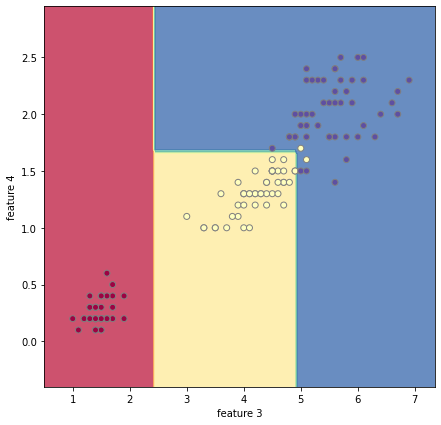

In [35]:
f1, f2 = 2, 3

plt.figure(figsize=(7, 7))

cm = plt.cm.Spectral

h = .05
x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

tree = ClassificationTree(max_depth=5, min_leaf_samples=1, min_delta_impurity=0.0)
tree.fit(X[:, [f1, f2]], y)

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.scatter(X[:, f1], X[:, f2], c=y, cmap=cm, edgecolor="grey")

plt.xlabel(f"feature {f1+1}")
plt.ylabel(f"feature {f2+1}")
plt.show()